# Credit card Fraud Detection


## Data Set Information:

* Source: https://www.kaggle.com/mlg-ulb/creditcardfraud

## Context
* It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

## Dataset
* The datasets contains transactions made by credit cards in September 2013 by european cardholders.
* This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

* It contains only numerical input variables which are the result of a **PCA transformation**. 
* Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. 
* Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
* The feature **'Time'** contains the seconds elapsed between each transaction and the first transaction in the dataset. 
* The feature **'Amount'** is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. 
* The feature **'Class'** is the response variable and it takes value 1 in case of fraud and 0 otherwise.




# Aim/Purpose

* The idea is create a machine learning model to:
    - Data Exploration/Visualization
        - Understand structure of the data.
    - Predict the **extreme rare fraud cases** with dimension reduced information due to PCA.
    - Determine factors which have the higher probability to predict the quality.
        - Reduce the dimension of variables. (Feature engineering)
    - Determine machine learning model for best classifying the wines. (Metric = recall in this case).
    
## The flaw of analysis:

* We do not consider **"amount"** in the default XGBoost **cost function**.
    - The accuracy should be lower by doing, but at least paying good result.
* Worth spending time investigating to penaltize higher weight on FP in **cost function** for four different scenarios as such:
    - True Positive (TP):
        - Model predicted **fraud** and it's a **fraud**.
        - Administrative cost that investigated the reason determining fraud.
    - False Positive (FP):
        - Model predicted **fraud** and it's a **not a fraud**:
        - Administrative cost that investigated the reason determining fraud.
    - False Negative (FN):
        - Model predicted **non-fraud** and it's **a fraud**:
        - Highest cost as credit default case were missed out.
    - True Negative (TN):
        - Model predicted **non-fraud** and it's  **not a fraud**:
        - No cost incurred.
     - Recall: True Positives/(True Positives + False Negatives):
         - **the amount of fraud cases our model is able to detect**
* Include all the data in data cleaning process; **does not remove outlier** as we might exclude rare cases which were fraud actually.          
* Do not include randomized grid search for hypertuning due to high conputational cost, and assumed the model was nicely tuned.

## Model:

* We used **XGboost algorithm** with **SMOTE** to oversample the **fraud cases**.
* **The advantages of model has been explained in /kaggle_winequality.**
* We further evaluate the model using **Area Under the Precision-Recall Curve (AUPRC)**.
* Recall will be priorised as to minimize possible cost by having the highest TP.

### Accuracy:
* The recall is the ratio $\frac{tp + fn}{(tp + tn + fp+ fn)}$
* Where tp is the number of true positives and fn the number of false negatives, and vice versas for others as labelled above.
* The accuracy is intuitively the ability of the classifier to correctly classify the samples.

### Recall:
* The recall is the ratio $\frac{tp}{(tp + fn)}$
* Where tp is the number of true positives and fn the number of false negatives. 
* The recall is intuitively the ability of the classifier to find all the positive samples.

### Precision:

* The precision is the ratio $\frac{tp}{(tp + fp)}$
* Where tp is the number of true positives and fp the number of false positives. 
* The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

### F1 score:

* F1 score, also known as balanced F-score or F-measure
* The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. 
* The relative contribution of precision and recall to the F1 score are equal.

$F1\ =\ 2 \times \ \frac{(precision \times recall)}{(precision + recall)}$

* In the multi-class and multi-label case, this is the average of the F1 score of each class with weighting depending on the average parameter.





In [1]:
import matplotlib.pyplot as plt
from datetime import timedelta
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from yellowbrick.classifier import ClassPredictionError, ROCAUC

import numpy as np
import pandas as pd
import matplotlib
import plotly.figure_factory as ff
import plotly.graph_objects as go
import scipy
import shap
import squarify
import seaborn as sns
import xgboost as xgb

shap.initjs()
np.random.seed(0)


Using TensorFlow backend.
C:\Users\moses\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
dr_workplace = 'C:\\Users\\moses\\OneDrive\\Documents\\machine learning\\kaggle_credit_card_fraud_detection'
df = pd.read_csv(dr_workplace + '\\creditcard.csv') # Load the data

In [3]:
df.describe()

# The fraud rate in the data is 0.17%, proves that the data itself is quite imbalanced.

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

# Checking the quaity of data.

* To see if we need further cleaning/preprocessing after checking the structure.
* Data looks clean, no null and missing value.
* The correlation can be ignored due to extreme imbalanced dataset.

In [7]:
details = rstr(df, 'Class')
details.sort_values(by='missing_ration', ascending=False)

Data shape: (284807, 31)
___________________________
Data types:
 float64    30
int64       1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr Class
Time,float64,284807,124592,0,0.0,"[[0.0, 1.0, 2.0, 4.0, 7.0, 9.0, 10.0, 11.0, 12...",-0.035568,-1.293530,-0.012323
V16,float64,284807,275663,0,0.0,"[[-0.47040052525947795, 0.463917041022171, -2....",-1.100966,10.419131,-0.196539
Amount,float64,284807,32767,0,0.0,"[[149.62, 2.69, 378.66, 123.5, 69.99, 3.67, 4....",16.977724,845.092646,0.005632
V28,float64,284807,275663,0,0.0,"[[-0.0210530534538215, 0.0147241691924927, -0....",11.192091,933.397502,0.009536
V27,float64,284807,275663,0,0.0,"[[0.13355837674038698, -0.00898309914322813, -...",-1.170209,244.989241,0.017580
V26,float64,284807,275663,0,0.0,"[[-0.189114843888824, 0.125894532368176, -0.13...",0.576693,0.919006,0.004455
V25,float64,284807,275663,0,0.0,"[[0.12853935827352803, 0.167170404418143, -0.3...",-0.415793,4.290412,0.003308
V24,float64,284807,275663,0,0.0,"[[0.0669280749146731, -0.33984647552912706, -0...",-0.552499,0.618871,-0.007221
V23,float64,284807,275663,0,0.0,"[[-0.110473910188767, 0.10128802125323402, 0.9...",-5.875140,440.088659,-0.002685
V22,float64,284807,275663,0,0.0,"[[0.277837575558899, -0.6386719527718511, 0.77...",-0.213258,2.832967,0.000805


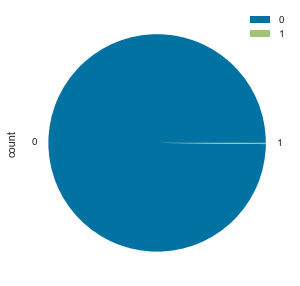

In [6]:
df_group_class = df.groupby('Class').agg({'Amount': ['count']})
df_group_class.plot.pie(y='Amount', figsize=(5, 5))

In [7]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,3), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,3), '% of the dataset')

No Frauds 99.827 % of the dataset
Frauds 0.173 % of the dataset


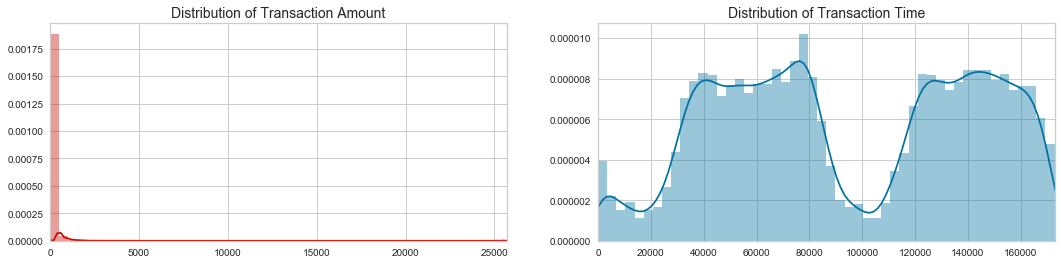

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

# Correlation matrix 

* Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.
* Lets shuffle the data before creating the subsamples.
* **The subsample is for creation of correlation analysis only, it wouldn't be used for traning of ML model.**

# Necessary of removal of outlier

* Removal of outlier might not be necessary as we might be missing out actual fraud cases.
* Moreover, We will be introducing SMOTE technique to oversample the minority rows.

In [9]:

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
178066,123462.0,-2.929579,-2.630494,1.775473,-2.310854,-0.490392,-0.042834,-1.674939,0.399247,-0.567327,...,-0.280585,-0.294464,-0.455937,0.479731,0.443785,-0.255994,-1.050257,0.587969,19.95,0
181966,125200.0,-0.769172,1.342212,-2.171454,-0.151513,-0.648374,-0.973504,-1.706658,0.313745,-1.982302,...,-0.036122,-0.753591,-0.047113,0.358493,-0.287407,0.476506,0.250531,0.250987,40.00,1
265205,161783.0,-0.161936,0.474341,-0.758422,-0.953533,0.751166,-1.570174,2.117030,-0.600490,0.069598,...,0.245031,0.766910,0.028772,-0.039268,-0.383179,0.067253,0.177143,0.049525,118.85,0
144754,86376.0,-0.670238,0.945206,0.610051,2.640065,-2.707775,1.952611,-1.624608,-5.229908,0.210202,...,-2.504450,1.436472,0.351542,0.648467,0.579681,0.075738,0.346717,0.282209,323.77,1
238222,149582.0,-4.280584,1.421100,-3.908229,2.942946,-0.076205,-2.002526,-2.874155,-0.856005,0.963674,...,-0.140062,-0.907720,-0.680108,-0.349170,0.056276,-1.149923,-1.809886,0.723051,1.10,1


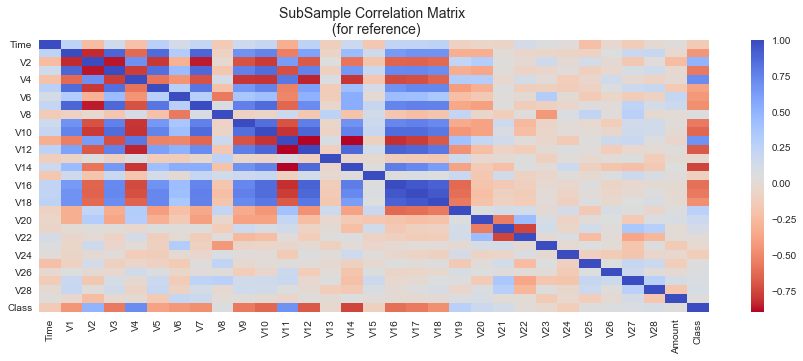

In [10]:
f, ax1 = plt.subplots(1, 1, figsize=(15,5))

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title('SubSample Correlation Matrix \n (for reference)', fontsize=14)
plt.show()

# SMOTE Technique (Over-Sampling):

* SMOTE stands for Synthetic Minority Over-sampling Technique. 
* Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. 
* This is another alternative for solving the "class imbalance problems".


# Understanding and Applying SMOTE:

## Solving the Class Imbalance: 
* SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class.

## Location of the synthetic points:
* SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points.

## Outcomes: 

* More information is retained since we didn't have to delete any rows unlike in random undersampling.
* Accuracy || Time Tradeoff: Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.

# Note in Applying:

* If we want to implement cross validation, remember to oversample or undersample your training data **during cross-validation**, not before!
* Don't use accuracy score as a metric with imbalanced datasets (will be usually high and misleading), instead use **f1-score, precision/recall score or confusion matrix**.
* We printed out accuracy for **reference only**.

In [11]:
# The target variable is 'Class'.
ignore_col_list = ['Time', 'Class']
metric_col_list = ['Class']
feature_names = pd.DataFrame(list(df), columns = ['a'])
feature_names = feature_names[~feature_names['a'].isin(ignore_col_list)]
feature_names = feature_names['a'].values.tolist()

X = df[feature_names]
y = df[metric_col_list]
X = X.values
y = y.values
#Model training

kf = StratifiedKFold(n_splits = 5)
for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    X_train_oversampled, y_train_oversampled = SMOTE().fit_sample(X_train, y_train)
    model = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=11,
                      min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.4,
                      objective= 'binary:logistic', nthread=4, scale_pos_weight=1, eval_metric = 'aucpr')
    model.fit(X_train_oversampled, y_train_oversampled)  
    y_pred = model.predict(X_test)
    print(f'For fold {fold}:')
    print(f'Accuracy: {model.score(X_test, y_test)}')


For fold 1:
Accuracy: 0.9994382219725431
For fold 2:
Accuracy: 0.9995962220427653
For fold 3:
Accuracy: 0.9994733238531627
For fold 4:
Accuracy: 0.9994031003669177
For fold 5:
Accuracy: 0.999420656238479


# Result:

* Let's look into **fraud cases only**.
* 83% precision, 84% recall and 83% recalls, which I personally think it's pretty good enough!

In [12]:
# Evaluate predictions
print('Accuracy of XBG Classifier Model on test set: {:.2%}'
     .format(accuracy_score(y_test, model.predict(X_test))))
print('*' * 60)
print('Confusion Matrix')
print(confusion_matrix(y_test, model.predict(X_test)))
print('*' * 60)
print('Classification Report')
print(classification_report(y_test, model.predict(X_test)))


Accuracy of XBG Classifier Model on test set: 99.94%
************************************************************
Confusion Matrix
[[56846    17]
 [   16    82]]
************************************************************
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.83      0.84      0.83        98

    accuracy                           1.00     56961
   macro avg       0.91      0.92      0.92     56961
weighted avg       1.00      1.00      1.00     56961



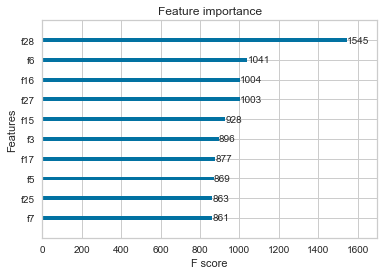

In [13]:
# The model has been defined as xgboost model in previous tab.
# plot feature importance
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(model, max_num_features=10) # top 10 most important features
plt.show()

# Finally, save the model

* Use **Pickle** package to save the trained model.
* To re-load the model, simply loaded_model = pickle.load(open(filename, 'rb'))

In [14]:
# save the model to disk
import pickle
filename = 'credit_card_fraud_detection.pkl'
pickle.dump(model, open(filename, 'wb'))